In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`


In [2]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [b0b7db55] ComponentArrays v0.13.12
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.91
  [587475ba] Flux v0.13.16
  [f6369f11] ForwardDiff v0.10.35
  [bd48cda9] GraphRecipes v0.5.12
  [86223c79] Graphs v1.8.0
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b2108857] Lux v0.4.53
  [429524aa] Optim v1.7.5
  [7f7a1694] Optimization v3.14.1
  [253f991c] OptimizationFlux v0.1.4
  [91a5bcdd] Plots v1.38.11
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.31.0
  [e88e6eb3] Zygote v0.6.61


In [3]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DifferentialEquations.DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff
using Graphs
using GraphRecipes
using RecursiveArrayTools
using Lux
using Lux.NNlib # to get access to additional activation functions
using Statistics # for covariance from sample

In [217]:
vcat(u_0, u_0)

4-element Vector{Float32}:
 100.0
  20.0
 100.0
  20.0

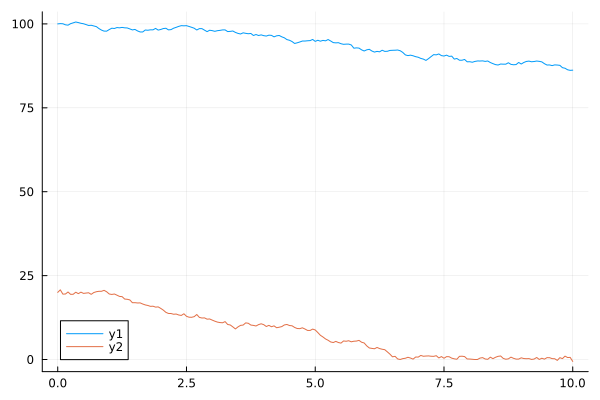

In [221]:
# set up problem: initial conditions, params, solver hyperparams
# make sure you match precisions, i.e., Float32 single precision
datasize = 201
tspan = (0.0f0, 10.0f0)
tsteps = range(tspan[1], tspan[2], length = datasize)
NOISE_STRUCT = zeros(Float32,2,4)
u_0 = Float32[
    100.0,
    20.0
]
u_0_OP_norm = vcat(u_0, u_0)

# produce NN for rates expressions in drift and diffusion functions of SDE
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,rebuild(p),st)[1]
    return [
        R4-(R1+R3),
        R3-(R2+R4)
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = ratesmodel(u,rebuild(p),st)[1].^(1/2)
    return [
        -R1_r 0.0 -R3_r R4_r;
        0.0 -R2_r R3_r -R4_r
    ]
end

# generate feedforward NN, probably better to not use ReLU at final layer to enforce positive outputs, has zero gradients
# try softplus instead which still maps negative elements to upper half plane, need to import NNlib for it: 
# https://stackoverflow.com/questions/49982438/how-to-restrict-the-output-of-neural-network-to-be-positive-in-python-keras
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, relu));
# per Prabhat suggestion, eliminate all ReLU! turn all to some other activation, e.g., softplus
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, softplus));
# it seems like the x3 output of ratesmodel is never large, perhaps info is lost early in training due to negative real line
# mapping to near zero, try tanh (symmetric odd about zero, has equal representation, but will be slower training) in middle layer
# but keep softplus on output to maintain positivity
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, softplus), Lux.Dense(16, 4, softplus));
# now non-dimensionalize the inputs by their u0 magnitude to speed up training
# doing so for the output layer will require you to know the dependencies of the rxn laws on inputs, here we assume this is known
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, tanh), Lux.Dense(16, 4, softplus));

# output normalization looks like X1,X2,X1,X2 since this is what we may consider the outputs to depend on
# actually produces really large gradients, not so useful yet? need to figure out better ways to normalize
# ratesmodel = Lux.Chain(x->x ./ u_0, Lux.Dense(2, 16, tanh), Lux.Dense(16, 4, softplus), x->x .* u_0_OP_norm)
ratesmodel = Lux.Chain(Lux.Dense(2, 16, tanh), Lux.Dense(16, 4, softplus))
p_nn, st = Lux.setup(Xoshiro(0), ratesmodel)

# positive test
ratesmodel(u_0,p_nn,st)

# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# reflecting condition, helps stabilize ensemble results
# see https://stackoverflow.com/questions/69049991/simulating-a-reflecting-boundary-sdeproblem
function affect!(integrator)
    if integrator.u[2] < 0
        integrator.u[2] = -integrator.u[2]
    end
end
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(p_nn)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')# , xlim = (0.0,10.0), ylim = (0,100))

# Positive Test: adjoint on the SDE solve using `sensealg`
## Solution: remove `save_everystep=false`

In [222]:
function loss_neuralsde(p,u=u_0)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    sol = solve(prob, EM(), dt = dt, saveat = dt; sensealg=BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)) #BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
    loss = sum(abs2,sol[:,:])
    return loss, sol
end

res_p = loss_neuralsde(flat,u_0)[2]
res = Zygote.gradient(p->loss_neuralsde(p,u_0)[1],flat)[1]
res2 = ForwardDiff.gradient(p -> loss_neuralsde(p, u_0)[1], flat)

116-element Vector{Float32}:
       0.0
     577.12463
       0.0
    -200.8794
       0.0
       0.0
       0.0
       0.0
   -1869.3046
       0.0
       0.0
       0.0
       0.0
       ⋮
  134840.61
    6315.306
   18305.969
  -64818.934
 -151331.19
   -4206.787
  -13402.578
   65753.945
 -151331.19
   -4206.787
  -13402.578
   65753.945

In [197]:
length(res_p.t)

201

# Get Ground Truth Moments

In [164]:
function trueSDEfunc!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
    end
end

function true_noise_func!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1, 1] = -sqrt(R1)
        du[1, 3] = -sqrt(R3)
        du[1, 4] = sqrt(R4)
        du[2, 2] = -sqrt(R2)
        du[2, 3] = sqrt(R3)
        du[2, 4] = -sqrt(R4)
    end
end

# new IC
u_0 = Float64[
    100.0,
    20.0
]
p_true = log.(Float64[
    0.1,
    0.2,
    0.2,
    0.5
])

# ground truth for two-pool model using ensemble of 100000 trajectories
# use callbacks from before, save_position = (false,false)
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol_true = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N)

# parse to remove failed simulations
parsed_sol_cb = [(sol_true.u[i].retcode != ReturnCode.Success ? nothing : sol_true.u[i]) for i in 1:length(sol_true.u)]
parsed_sol_cb = parsed_sol_cb[parsed_sol_cb.!=nothing]
truemean_cb = mean(parsed_sol_cb)[:,:]
truevar_cb = var(parsed_sol_cb)[:, :]
VA_true = VectorOfArray(parsed_sol_cb) # vector of arrays upgrades indexing into array capabilities for noobs like me
truecov_cb = [Statistics.cov(VA_true[1,i,:],VA_true[2,i,:]) for i in 1:length(sol_true[1].t)] # touches each time point's state distributions

# number/proportion of failed simulations
println("$(N-length(parsed_sol_cb)) failed simulations, or $(1-length(parsed_sol_cb)/N)")

0 failed simulations, or 0.0


In [85]:
length(sol[1].t)

201

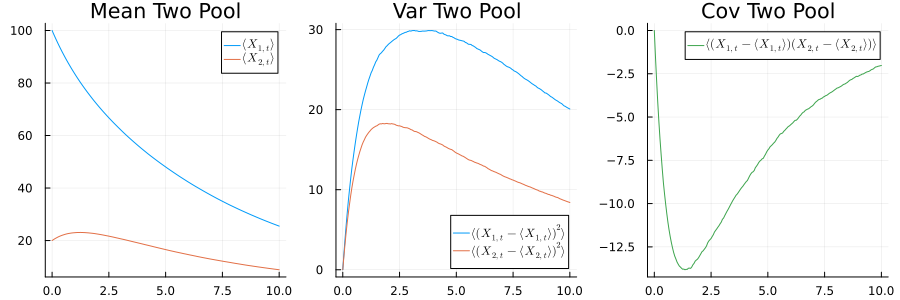

In [175]:
# plot ground truth, i.e., total 5 moments of data
p_twopool_mean = plot(
    sol_true.u[1].t,
    truemean_cb',
    title = "Mean Two Pool", 
    label = [L"\langle X_{1,t} \rangle" L"\langle X_{2,t} \rangle"]
) # two time series here
p_twopool_var = plot(
    sol_true.u[1].t,
    truevar_cb', 
    title = "Var Two Pool",
    label = [L"\langle (X_{1,t} - \langle X_{1,t} \rangle)^2 \rangle" L"\langle (X_{2,t} - \langle X_{2,t} \rangle)^2 \rangle"]
) # two time series here
p_twopool_cov = plot(
    sol_true.u[1].t,
    truecov_cb,
    title = "Cov Two Pool",
    label = L"\langle (X_{1,t} - \langle X_{1,t} \rangle) (X_{2,t} - \langle X_{2,t} \rangle) \rangle",
    legend = :topright,
    color = 3
) # one time series here

plot(
    p_twopool_mean,
    p_twopool_var,
    p_twopool_cov,
    layout = (1,3),
    size = (900,300)
)

# Training on non-zero ICs

In [204]:
# w/o ensembling, more costly to compute when doing back prop
# need large n to get reliable covariance estimates for a batch of simulations
function loss_neuralsde2(p,u=u_0,n=1000)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    res = map(
        (x->solve(prob, EM(), dt = dt, saveat = dt; sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))),
        [u_0 for i in 1:n]
    )
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
    means = mean(arr, dims = 3)
    vars = var(arr, dims = 3, mean = means)
    covs = [Statistics.cov(VA[1,i,:],VA[2,i,:]) for i in 1:length(VA[1,:,1])]

    # elastic net, but also put the moments in the same magnitude, i.e., abs instead of abs2 for variances
    # this will also decrease the magnitude of your gradients to make training smoother!
    loss = sum(abs2, truemean_cb .- means) + sum(abs, truevar_cb .- vars) + sum(abs, truecov_cb .- covs) # + 1.0 * sum(abs2, p) + 1.0 * sum(abs, p) # elastic net without hyperparameters optimized
    
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=2
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
# test_loss = loss_neuralsde2(flat)
# res = Zygote.gradient(p->loss_neuralsde2(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde2(p,u_0,n),flat)

116-element Vector{Float64}:
      0.0
    146.5421207037973
      0.0
    -58.130157935001314
      0.0
      0.0
      0.0
      0.0
   -815.3791730452378
      0.0
      0.0
      0.0
      0.0
      ⋮
  75787.5988052666
  -7695.651068693438
  17872.423895326236
 -42174.466498139926
 -77647.57294928127
   7483.573970573263
  -9638.072867092103
  30807.434765337028
 -77647.57294928127
   7483.573970573263
  -9638.072867092103
  30807.434765337028

In [209]:
# w/ ensembling + will be much easier to parallelize for multi-node computing, ensembling courtesy of Nathan Stover
function loss_neuralsde3(p,u=u_0,n=1000)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    ensembleprob = EnsembleProblem(prob)
    sols = solve(
        ensembleprob,
        EM(), 
        dt=dt, 
        saveat = dt, 
        trajectories = n;
        sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)
    )
    means = mean(sols, dims = 3)[:, :]
    vars = var(sols, dims = 3)[:, :]
    covs = [Statistics.cov(sols[1,i,:],sols[2,i,:]) for i in 1:length(sols[1,:,1])]
    
    loss = sum(abs2, truemean_cb .- means) + sum(abs, truevar_cb .- vars) + sum(abs, truecov_cb .- covs)
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=2
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
test_loss = loss_neuralsde3(flat)
# res = Zygote.gradient(p->loss_neuralsde3(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde3(p,u_0,n),flat)

116-element Vector{Float64}:
      0.0
    167.34285913109312
      0.0
    -64.37694473910973
      0.0
      0.0
      0.0
      0.0
   -763.2982673938758
      0.0
      0.0
      0.0
      0.0
      ⋮
  75676.5100437506
  -9270.051080394713
  19403.81122655955
 -49012.963685205825
 -71008.32147290948
   4775.837882671237
 -17549.33465060049
  30601.237634373603
 -71008.32147290948
   4775.837882671237
 -17549.33465060049
  30601.237634373603

In [230]:
# the ForwardDiff version of this optimization
# https://docs.sciml.ai/Optimization/stable/API/optimization_function/#Optimization.AutoForwardDiff
opt = ADAM(0.001)
losses = []
params_list = []
MAX_ITERS = 2000 # around 20 seconds/iter on KKG comp with tanh + callbacks, so ~5hrs for 500 iters

# save progress of solution, https://docs.sciml.ai/Optimization/stable/API/solve/#CommonSolve.solve-Tuple{OptimizationProblem,%20Any}
function callback(params,loss_val)
    # record round number, loss, and params
    println("Round $(length(params_list)) training loss: $(loss_val)")
    push!(losses,loss_val)
    push!(params_list,params)
    length(params_list) >= MAX_ITERS
end

# First round of training with n = 10
# need to add a slight positive value to the IC to excite non-zero dynamics
t1 = time_ns()
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde2(x,u_0), adtype)
optprob = Optimization.OptimizationProblem(optf, flat)
result1 = Optimization.solve(optprob, opt, maxiters = MAX_ITERS, callback=callback);
t2 = time_ns()
println("Total time elapsed: $((t2-t1)/1.0e9) seconds")
println("Total time / epoch: $((t2-t1)/1.0e9/MAX_ITERS) seconds")

Round 0 training loss: 453111.71480235056
Round 1 training loss: 455036.8080381227
Round 2 training loss: 457430.8788346929
Round 3 training loss: 446478.3286702829
Round 4 training loss: 456731.81538835494
Round 5 training loss: 445094.79942922055
Round 6 training loss: 443102.21480478835
Round 7 training loss: 433388.0267519618
Round 8 training loss: 438180.3116955233
Round 9 training loss: 442019.77816894226
Round 10 training loss: 433878.30960943195
Round 11 training loss: 432456.5825272158
Round 12 training loss: 431809.18888992316
Round 13 training loss: 435255.2583296017
Round 14 training loss: 424359.848875222
Round 15 training loss: 419339.26568435604
Round 16 training loss: 421535.0764216173
Round 17 training loss: 420142.8421910788
Round 18 training loss: 417371.09062651097
Round 19 training loss: 420723.0969050624
Round 20 training loss: 413139.2524132155
Round 21 training loss: 408794.4847873452
Round 22 training loss: 408010.3436901979
Round 23 training loss: 406368.80871

Round 191 training loss: 93973.18312561422
Round 192 training loss: 89261.41975855293
Round 193 training loss: 84338.80678459535
Round 194 training loss: 87580.66518280236
Round 195 training loss: 96940.9620163082
Round 196 training loss: 88991.91865567338
Round 197 training loss: 81652.79731173479
Round 198 training loss: 89457.72698843923
Round 199 training loss: 83545.09637111827
Round 200 training loss: 84642.9356964551
Round 201 training loss: 79916.25780175507
Round 202 training loss: 85601.6064071709
Round 203 training loss: 77246.28360117004
Round 204 training loss: 74566.2624810185
Round 205 training loss: 77691.84786619408
Round 206 training loss: 76737.1540111819
Round 207 training loss: 78153.267600839
Round 208 training loss: 70959.17973059032
Round 209 training loss: 74219.45878185733
Round 210 training loss: 72466.55096001262
Round 211 training loss: 72335.2341688501
Round 212 training loss: 69952.19778754775
Round 213 training loss: 75472.94727356048
Round 214 training 

Round 381 training loss: 17283.539311055556
Round 382 training loss: 18775.713155582052
Round 383 training loss: 19873.43971511294
Round 384 training loss: 17295.940149817907
Round 385 training loss: 20265.575648319445
Round 386 training loss: 19060.078223715143
Round 387 training loss: 20924.46893816289
Round 388 training loss: 17906.15189037993
Round 389 training loss: 20308.46082956633
Round 390 training loss: 17317.340374838335
Round 391 training loss: 21434.30958496429
Round 392 training loss: 17669.46831818785
Round 393 training loss: 21615.30595403907
Round 394 training loss: 19426.887737750214
Round 395 training loss: 16801.003934261335
Round 396 training loss: 18333.81101116652
Round 397 training loss: 19770.076899257318
Round 398 training loss: 16999.554472856144
Round 399 training loss: 18024.61653500461
Round 400 training loss: 16886.089916891957
Round 401 training loss: 18342.458576000274
Round 402 training loss: 19131.901630711516
Round 403 training loss: 15403.4585408998

Round 569 training loss: 11119.136110156978
Round 570 training loss: 9043.442013830287
Round 571 training loss: 11186.895884934342
Round 572 training loss: 10830.087427223318
Round 573 training loss: 10955.424070983367
Round 574 training loss: 10207.395682599565
Round 575 training loss: 9597.897451790344
Round 576 training loss: 10206.25913320237
Round 577 training loss: 9319.354100608576
Round 578 training loss: 9523.935322477264
Round 579 training loss: 10909.915920966643
Round 580 training loss: 10884.27043636635
Round 581 training loss: 10547.486944860859
Round 582 training loss: 10796.117196761974
Round 583 training loss: 9469.197446181406
Round 584 training loss: 11742.423526659348
Round 585 training loss: 12712.65823067038
Round 586 training loss: 10350.025104006376
Round 587 training loss: 9250.388283069822
Round 588 training loss: 9290.61680200879
Round 589 training loss: 10221.537224257965
Round 590 training loss: 10541.628430743209
Round 591 training loss: 10896.95523899746


Round 760 training loss: 7712.427851899516
Round 761 training loss: 6877.53043930929
Round 762 training loss: 6837.804679896615
Round 763 training loss: 7184.301101082645
Round 764 training loss: 6974.307889362228
Round 765 training loss: 8283.042571199136
Round 766 training loss: 7366.0268568621395
Round 767 training loss: 6754.948250870693
Round 768 training loss: 7922.209156535309
Round 769 training loss: 6860.987391285324
Round 770 training loss: 6036.1435233403945
Round 771 training loss: 7821.686517910619
Round 772 training loss: 7708.563567859395
Round 773 training loss: 5935.298056163496
Round 774 training loss: 6254.543477122628
Round 775 training loss: 6495.17953640771
Round 776 training loss: 7699.699395380641
Round 777 training loss: 6688.180756460382
Round 778 training loss: 7435.178932848079
Round 779 training loss: 7234.586170051296
Round 780 training loss: 6605.102170248161
Round 781 training loss: 6087.503838230359
Round 782 training loss: 5705.205488285754
Round 783 t

Round 951 training loss: 5934.958239056661
Round 952 training loss: 5243.685692173615
Round 953 training loss: 4750.1354750448845
Round 954 training loss: 5331.363461869343
Round 955 training loss: 5424.826201796814
Round 956 training loss: 5154.525210732858
Round 957 training loss: 4832.907425438498
Round 958 training loss: 5570.676520566103
Round 959 training loss: 5914.14764407902
Round 960 training loss: 5658.170378803648
Round 961 training loss: 5226.424800206731
Round 962 training loss: 5826.718443961255
Round 963 training loss: 5983.221750037166
Round 964 training loss: 6503.825859431257
Round 965 training loss: 5065.6486946163295
Round 966 training loss: 5884.034265098149
Round 967 training loss: 5972.286293382167
Round 968 training loss: 4494.570517268051
Round 969 training loss: 6458.562072528048
Round 970 training loss: 6127.077884131326
Round 971 training loss: 4423.4950849501065
Round 972 training loss: 5404.964786852495
Round 973 training loss: 5129.556610074369
Round 974

Round 1139 training loss: 4997.546168819279
Round 1140 training loss: 4598.174141138281
Round 1141 training loss: 4945.476805206363
Round 1142 training loss: 5617.4043138273155
Round 1143 training loss: 4705.3851320782305
Round 1144 training loss: 5057.062306416129
Round 1145 training loss: 4378.995345217742
Round 1146 training loss: 4468.227812884539
Round 1147 training loss: 4513.087200502294
Round 1148 training loss: 4782.41161444962
Round 1149 training loss: 4392.052453469942
Round 1150 training loss: 4746.229195896163
Round 1151 training loss: 5363.167490844853
Round 1152 training loss: 4582.10405202141
Round 1153 training loss: 4705.431423629458
Round 1154 training loss: 4709.075367579186
Round 1155 training loss: 4145.519199593227
Round 1156 training loss: 5165.742336939138
Round 1157 training loss: 4866.770609323011
Round 1158 training loss: 4345.078045156658
Round 1159 training loss: 4932.694593462851
Round 1160 training loss: 4949.75734457669
Round 1161 training loss: 5130.02

Round 1325 training loss: 4323.403474294861
Round 1326 training loss: 5218.460416730718
Round 1327 training loss: 3687.0820861912935
Round 1328 training loss: 4669.498037979389
Round 1329 training loss: 3838.429277625871
Round 1330 training loss: 3307.2973055024704
Round 1331 training loss: 3592.683088173472
Round 1332 training loss: 4294.080544651666
Round 1333 training loss: 3976.472133125676
Round 1334 training loss: 4377.910115414092
Round 1335 training loss: 4284.7741536844405
Round 1336 training loss: 4530.55805399973
Round 1337 training loss: 4700.400590217884
Round 1338 training loss: 4509.76607049238
Round 1339 training loss: 3771.0411675036703
Round 1340 training loss: 3506.5809137693395
Round 1341 training loss: 4456.755519923621
Round 1342 training loss: 4662.084360340234
Round 1343 training loss: 3786.14157730074
Round 1344 training loss: 3706.7195997608424
Round 1345 training loss: 4286.747465444088
Round 1346 training loss: 4132.385180470839
Round 1347 training loss: 418

Round 1511 training loss: 3519.814453192752
Round 1512 training loss: 4409.375181793817
Round 1513 training loss: 3050.718638372766
Round 1514 training loss: 4300.006338961561
Round 1515 training loss: 3461.9410005654127
Round 1516 training loss: 3263.512899844636
Round 1517 training loss: 3216.9919700897476
Round 1518 training loss: 4476.4033352689385
Round 1519 training loss: 4184.201517589918
Round 1520 training loss: 3167.6750502539708
Round 1521 training loss: 3009.913850408181
Round 1522 training loss: 4061.4722546975254
Round 1523 training loss: 4852.708193850859
Round 1524 training loss: 4101.687882520819
Round 1525 training loss: 4336.543742013479
Round 1526 training loss: 3815.8739068870227
Round 1527 training loss: 3552.4164743528518
Round 1528 training loss: 3797.869411647408
Round 1529 training loss: 3956.6649601086037
Round 1530 training loss: 3422.967340353228
Round 1531 training loss: 3685.82200712353
Round 1532 training loss: 3764.6943122574958
Round 1533 training loss

Round 1696 training loss: 3859.3967671009295
Round 1697 training loss: 2860.262064646552
Round 1698 training loss: 4255.182317457611
Round 1699 training loss: 3156.246001113608
Round 1700 training loss: 3777.665898933324
Round 1701 training loss: 3336.89016183136
Round 1702 training loss: 3544.2330756778533
Round 1703 training loss: 3495.2388045197376
Round 1704 training loss: 3350.92101945173
Round 1705 training loss: 3792.934892886975
Round 1706 training loss: 3062.992161323443
Round 1707 training loss: 3734.2687731071514
Round 1708 training loss: 3758.5110167366392
Round 1709 training loss: 3362.392467592389
Round 1710 training loss: 4042.4008764402165
Round 1711 training loss: 3865.9700637958617
Round 1712 training loss: 2589.3325810678216
Round 1713 training loss: 3954.5269431741763
Round 1714 training loss: 4145.625807562883
Round 1715 training loss: 3053.881721097615
Round 1716 training loss: 3426.467672722006
Round 1717 training loss: 4461.123607273525
Round 1718 training loss:

Round 1881 training loss: 3473.380729818518
Round 1882 training loss: 3191.9540062188216
Round 1883 training loss: 3079.3569952317025
Round 1884 training loss: 3632.643765750544
Round 1885 training loss: 3614.209781289347
Round 1886 training loss: 2681.0931969808125
Round 1887 training loss: 3911.539333747602
Round 1888 training loss: 4424.032753293117
Round 1889 training loss: 3189.194492407717
Round 1890 training loss: 3122.0366887310506
Round 1891 training loss: 3075.0885419434635
Round 1892 training loss: 3418.201127838056
Round 1893 training loss: 2536.49192625325
Round 1894 training loss: 3448.344513331058
Round 1895 training loss: 3563.995753139704
Round 1896 training loss: 3604.023911620907
Round 1897 training loss: 2781.9578647538137
Round 1898 training loss: 2883.8047153144594
Round 1899 training loss: 2505.9484777334337
Round 1900 training loss: 3448.773477849395
Round 1901 training loss: 3384.730620145431
Round 1902 training loss: 3269.8034183163527
Round 1903 training loss

In [ ]:
# Without ensembling, loss_neuralsde2 + forwarddiff + no nondimensionalization
# Round 0 training loss: 453418.0504395511
# Round 1 training loss: 462522.7751419472
# Round 2 training loss: 444287.04479335964
# Round 3 training loss: 449228.1596051218
# Round 4 training loss: 441237.5707053234
# Total time elapsed: 228.0132093 seconds

# # With Ensembling, loss_neuralsde3 + forwarddiff + no nondimensionalization
# Round 0 training loss: 458726.2071952732
# Round 1 training loss: 452425.5253792036
# Round 2 training loss: 451174.52631210216
# Round 3 training loss: 448231.7828383395
# Round 4 training loss: 449727.0752642476
# Total time elapsed: 1092.5931754 seconds
#

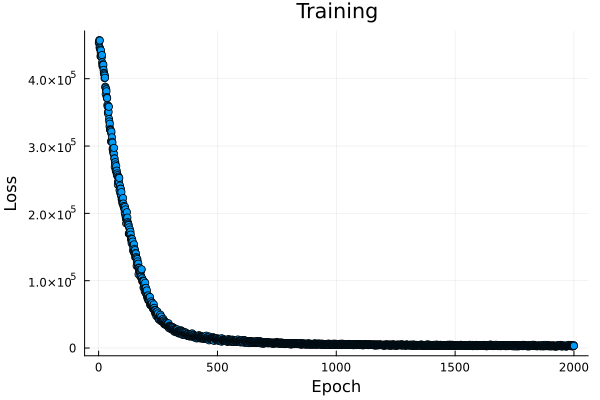

In [231]:
plot(1:MAX_ITERS,losses,ylabel = "Loss", xlabel = "Epoch", markershape=:circle, label="", title="Training")

In [248]:
# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(result1.u)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)
N = 10000
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, EM(), dt=0.05, saveat=0.05; trajectories = N, sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
trained_means = mean(sol, dims = 3)[:,:]
trained_vars = var(sol, dims = 3, mean = trained_means)[:,:]
trained_covs = [Statistics.cov(sol[1,i,:],sol[2,i,:]) for i in 1:length(sol[1,:,1])]

201-element Vector{Float32}:
  0.0
 -0.30198443
 -0.61013633
 -0.9224499
 -1.272324
 -1.5709558
 -1.8899802
 -2.236286
 -2.587642
 -2.9460254
 -3.258437
 -3.6683352
 -4.0671725
  ⋮
 -3.3594136
 -3.4215062
 -3.4421947
 -3.4836953
 -3.5360801
 -3.5439463
 -3.619687
 -3.6655395
 -3.6937537
 -3.7178092
 -3.712169
 -3.6737971

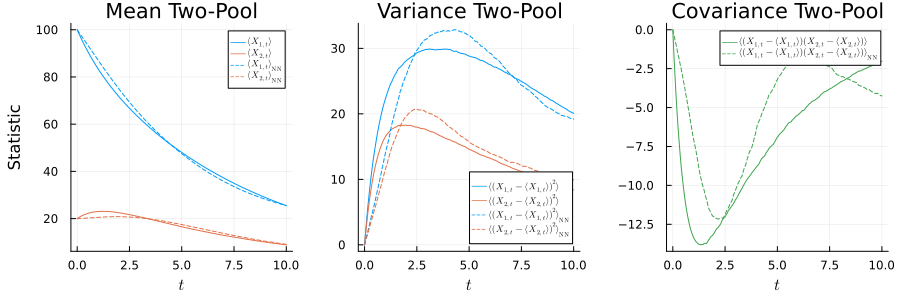

In [246]:
# plot ground truth, i.e., total 5 moments of data
p_twopool_mean = plot(
    sol_true.u[1].t,
    truemean_cb',
    title = "Mean Two-Pool", 
    label = [L"\langle X_{1,t} \rangle" L"\langle X_{2,t} \rangle"],
    color = [1 2],
    legendfontsize=6,
    ylabel = "Statistic"
) # two time series here

p_twopool_var = plot(
    sol_true.u[1].t,
    truevar_cb', 
    title = "Variance Two-Pool",
    label = [L"\langle (X_{1,t} - \langle X_{1,t} \rangle)^2 \rangle" L"\langle (X_{2,t} - \langle X_{2,t} \rangle)^2 \rangle"],
    color = [1 2],
    legend = :bottomright,
    legendfontsize=6
) # two time series here

p_twopool_cov = plot(
    sol_true.u[1].t,
    truecov_cb,
    title = "Covariance Two-Pool",
    label = L"\langle (X_{1,t} - \langle X_{1,t} \rangle) (X_{2,t} - \langle X_{2,t} \rangle) \rangle",
    legend = :topright,
    color = 3,
    legendfontsize=6
) # one time series here

# plot training results
plot!(
    p_twopool_mean,
    sol[1].t,
    trained_means', 
    color = [1 2],
    linestyle=[:dash :dash],
    label = [L"$\langle X_{1,t} \rangle_{\textrm{NN}}$" L"$\langle X_{2,t} \rangle_{\textrm{NN}}$"]
)
plot!(
    p_twopool_var, 
    sol[1].t,
    trained_vars', 
    color = [1 2], 
    linestyle=[:dash :dash],
    label = [L"\langle (X_{1,t} - \langle X_{1,t} \rangle)^2 \rangle_{\textrm{NN}}" L"\langle (X_{2,t} - \langle X_{2,t} \rangle)^2 \rangle_{\textrm{NN}}"]
)
plot!(
    p_twopool_cov, 
    sol[1].t,
    trained_covs,
    color = 3,
    linestyle = :dash,
    label = L"\langle (X_{1,t} - \langle X_{1,t} \rangle) (X_{2,t} - \langle X_{2,t} \rangle) \rangle_\textrm{NN}"
)

# aggregated plot
plot(
    p_twopool_mean,
    p_twopool_var,
    p_twopool_cov,
    layout = (1,3),
    size = (900,300),
    xlabel = L"t",
    bottommargin = 5Plots.mm,
    leftmargin = 5Plots.mm
)

In [247]:
ratesmodel(u_0,rebuild(result1.u),st)

(Float32[6.999346, 5.424981, 6.006179, 0.041064806], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [ ]:
#